# Download the require data
- data_test_file.pkl in the current directory
- train/event[n].pkl with the training data from Cern

# Load the data

I used code from the starting notebook to set this up. The end result is a dataframe with the labels and the 100 inputs (flattened the 10x10 images).

In [1]:
#Import libraries to load and process data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import glob

In [2]:
# replace by your own file path
pkl_file = open('event7.pkl', 'rb')
event1 = pickle.load(pkl_file)

In [3]:
# get the data and target
data,target=event1[0],event1[1]
target=target.astype('int')

In [4]:
# code to particle name dictionary -- more here : 
dic_types={11: "electron", 13 : "muon", 211:"pion", 321:"kaon",2212 : "proton"}

In [5]:
# Getting all the data
#dic_types={11: "electron", 13 : "muon", 211:"pion", 321:"kaon",2212 : "proton"}
X = []
y = []
pkls = glob.glob('data_test_file/*.pkl') # I didn't download all of them
for pkl in pkls:
  try:
    pkl_file = open(pkl, 'rb')
    event1 = pickle.load(pkl_file) 
# get the data and target
    data,target=event1[0],event1[1]
    # Some had np arrays in y. Skip those
    skip = False
    for t in target:
      if type(t) != np.int64:
        skip=True
    if not skip:
      X += [d for d in data]
      y += [t for t in target]
  except:
    print('problem with file', pkl)

In [6]:
import pandas as pd
df = pd.DataFrame({
    'y':target
})
df['class'] = df['y'].map(dic_types)
for i in range(100):
  df[str(i)] = [x.flatten()[i] for x in data]
df.sample(5)

,y,class,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
2480,211,pion,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
500,211,pion,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
306,211,pion,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1815,211,pion,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
313,321,kaon,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [7]:
df.groupby('class').count()['y'] # What's the distribution?

class
electron       8
kaon         404
muon           2
pion        2356
proton       286
Name: y, dtype: int64

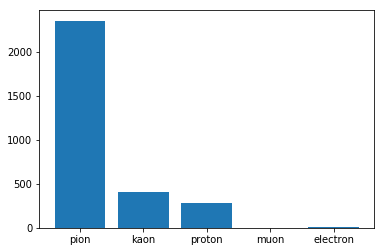

In [8]:
from collections import Counter

plt.bar(range(len(dic_types)),list(Counter(target).values()))
plt.xticks(range(len(dic_types)), [dic_types[i] for i in list(Counter(target).keys())])

plt.show()

In [9]:
df1= df.drop('class', axis=1)
y1 = df1.y
X1= df1.drop('y', axis=1)

In [10]:
print(X1.shape, y1.shape)

(3056, 100) (3056,)


# Modelling step!

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X1,y1, test_size=0.20, random_state=42)

In [12]:
#new shape of our data
np.array(X_train).shape, np.array(y_train).shape

((2444, 100), (2444,))

In [13]:
# particle distribution in our training
Counter(y_train)

Counter({321: 326, 211: 1876, 2212: 235, 11: 6, 13: 1})

In [14]:
from sklearn.ensemble import RandomForestClassifier


# Create and train a model

rf = RandomForestClassifier(n_estimators=1500, max_depth=1, class_weight= 'balanced_subsample', random_state=42) 
rf.fit(X_train, y_train)
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.3281505728314239
0.272875816993464


In [15]:
#print(rf.feature_importances_)
rf.get_params
#class_weight={11: 299, 13: 1387, 211: 1, 321: 3,2212: 7},

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=1500, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)>

In [16]:
from sklearn.metrics import confusion_matrix

# How well does it do?
confusion_matrix(y_test, rf.predict(X_test))

array([[  0,   0,   1,   0,   1],
       [  0,   0,   1,   0,   0],
       [ 59,   0, 138,  81, 202],
       [  8,   0,  28,  12,  30],
       [  8,   0,  19,   7,  17]], dtype=int64)

In [17]:
rf.classes_

array([  11,   13,  211,  321, 2212])

In [18]:
# Predict probabilities for X_test
preds = rf.predict_proba(X_test)

In [19]:
# Trying to recreate scoring...
from sklearn.metrics import log_loss

flat_preds = np.concatenate([preds[:,i] for i in range(5)])
flat_trues = np.concatenate([(np.asarray(y_test)==rf.classes_[i]).astype(int) for i in range(5)])
log_loss(flat_trues, flat_preds)

0.46639281566283963

# making predictions and submission

In [20]:
pkl_file = open('data_test_file.pkl', 'rb')
test = pickle.load(pkl_file)

In [21]:
ss = pd.DataFrame({
    'image':[t[0] for t in test]
})
ss.head()

,image
0,0
1,1
2,2
3,3
4,4


In [22]:
test_preds = rf.predict_proba([t[1].flatten() for t in test])

In [23]:
for i in range(len(rf.classes_)):
  ss[rf.classes_[i]] = test_preds[:,i]
ss.head()

,image,11,13,211,321,2212
0,0,0.181923,0.075338,0.249129,0.247718,0.245891
1,1,0.208744,0.086163,0.232431,0.237173,0.235489
2,2,0.224816,0.081285,0.229196,0.234999,0.229704
3,3,0.196716,0.107099,0.230243,0.228569,0.237373
4,4,0.190115,0.096008,0.237497,0.238129,0.238251


In [24]:
ss.to_csv('submission1.csv', index=False)